# Lab 7.06 - Time series analysis

In [2]:
# Package imports

## Exercise 6: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index:

In [6]:
TRAIN('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date']).set_index(['date'])
print(covid19.columns)

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vac

Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

<Axes: xlabel='date'>

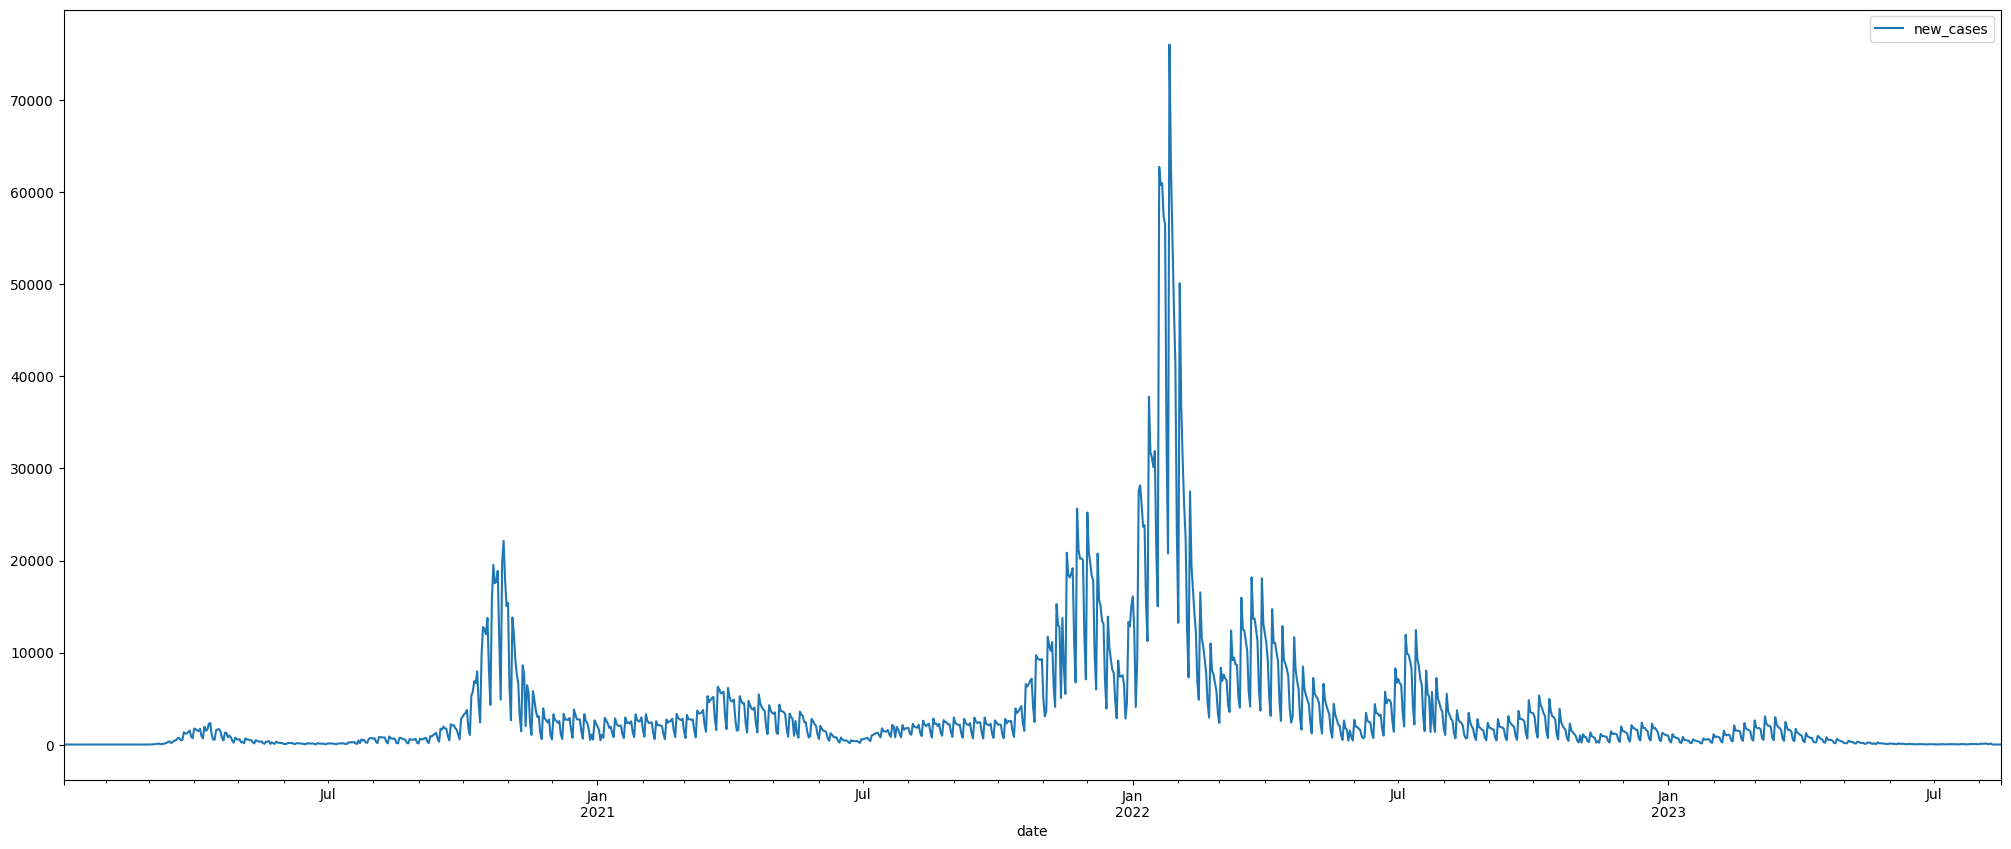

In [15]:
covid19_be = covid19[covid19.location == "Belgium"]

covid19_be.plot(y="new_cases", figsize=[25, 5])

### Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

/tmp/ipykernel_19452/3106302432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_be['SMA7'] = covid19_be['new_cases'].rolling(window=7).mean()
/tmp/ipykernel_19452/3106302432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_be['SMA30'] = covid19_be['new_cases'].rolling(window=30).mean()


<Axes: title={'center': 'New cases in Belgium'}, xlabel='date'>

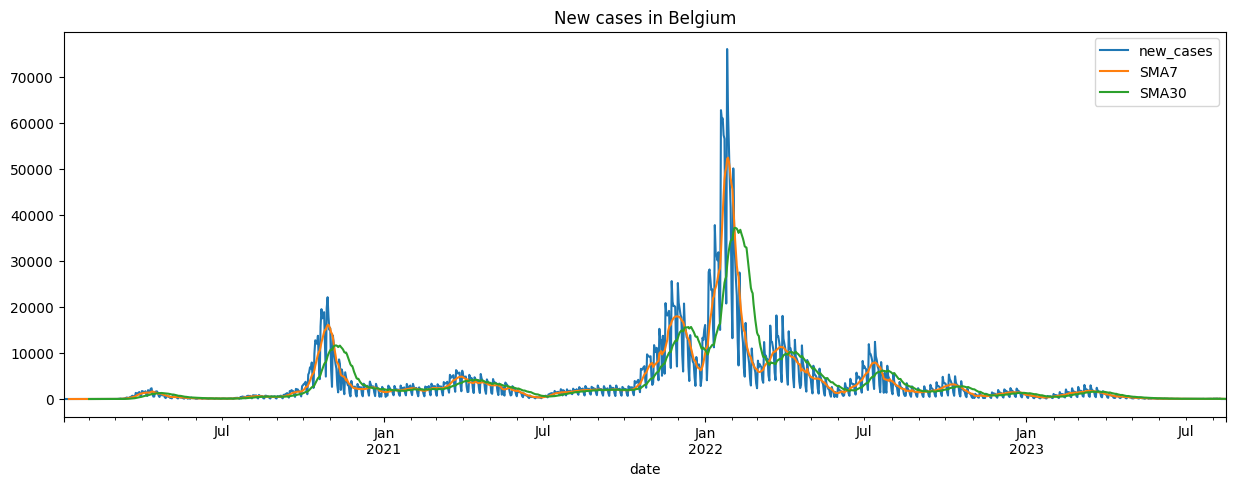

In [18]:
# add simple moving average to covid19_be
covid19_be['SMA7'] = covid19_be['new_cases'].rolling(window=7).mean()
covid19_be['SMA30'] = covid19_be['new_cases'].rolling(window=30).mean()

covid19_be.plot(figsize=(15, 5), y=['new_cases', 'SMA7', 'SMA30'], title='New cases in Belgium')

### Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

<Axes: xlabel='date'>

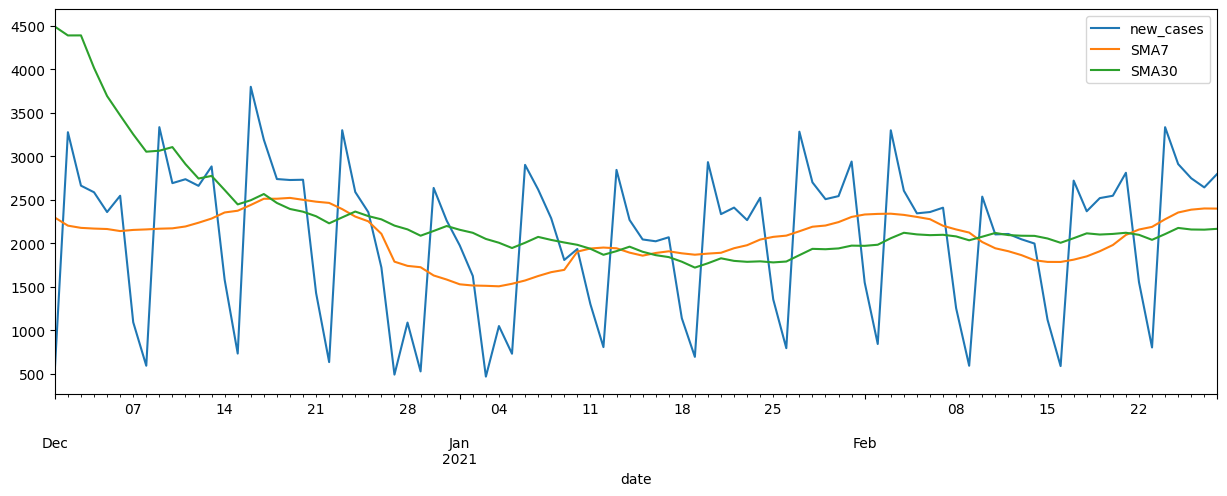

In [32]:
selectedBelCovid = covid19_be[pd.Timestamp("2020-12-01"):pd.Timestamp("2021-02-28")]
selectedBelCovid.plot(y=["new_cases", "SMA7", "SMA30"], figsize=(15, 5))



Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

<Axes: xlabel='date'>

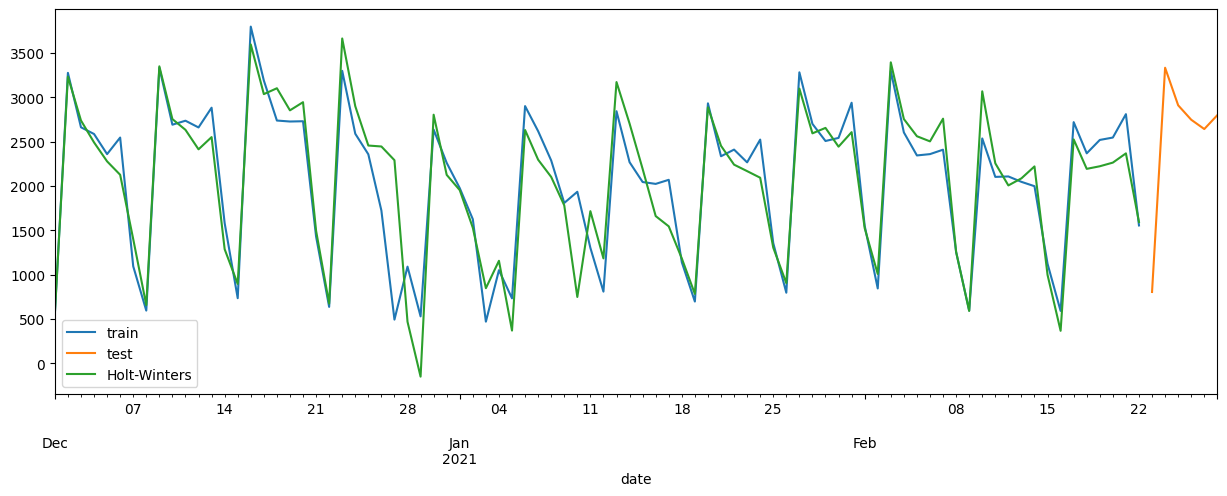

In [35]:
seasonal_periods = 7
train = selectedBelCovid.new_cases[:84]
test = selectedBelCovid.new_cases[84:]

covid_hw = ExponentialSmoothing(train,
    trend='add', seasonal = 'add',
    seasonal_periods=seasonal_periods, freq='D').fit()

train.plot(legend=True, label='train')
test.plot(legend=True, label='test', figsize=(15, 5))
covid_hw.fittedvalues.plot(legend=True, label='Holt-Winters')

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

Text(0.5, 1.0, 'train, test, fitted and predicted values using Holt-Winters')

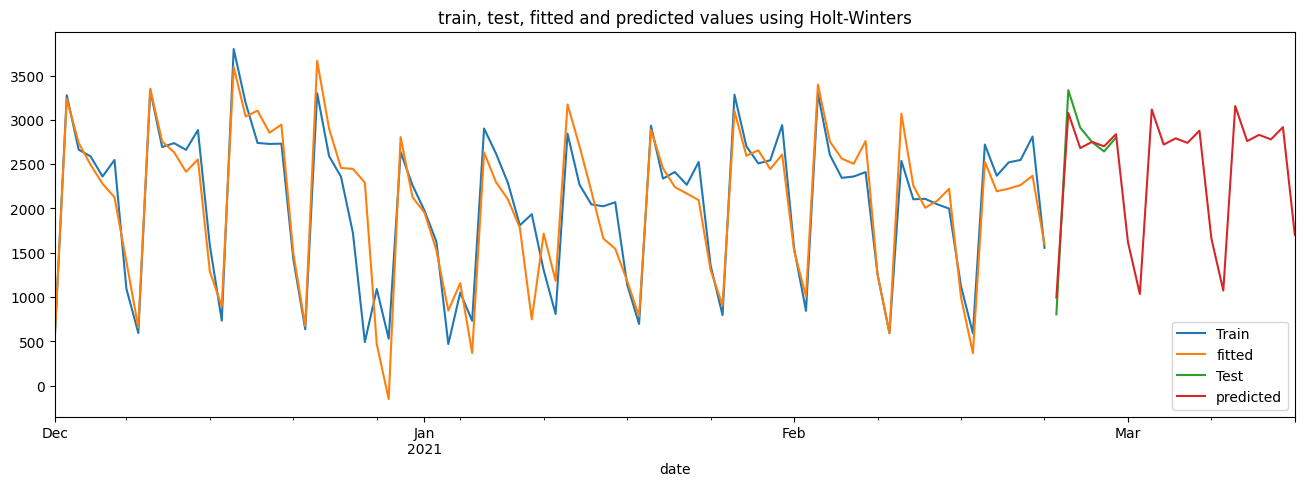

In [38]:
covid_predicted = covid_hw.forecast(21)

train.plot(label='Train', legend=True)
covid_hw.fittedvalues.plot(label="fitted", legend=True)

test.plot(label='Test', legend=True)
covid_predicted.plot(label="predicted", legend=True, figsize=(16, 5))

plt.title("train, test, fitted and predicted values using Holt-Winters")

### Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   25408.902 |  159.402 |  855.684 |
| 2021-03-01 to 2021-03-14 |  154280.817 |  392.786 |  895.531 |
| 2021-03-01 to 2021-03-21 | 1048835.781 | 1024.127 | 1052.978 |

In [57]:
print(f"MSE: {mean_squared_error(test, covid_predicted[:6])}, Squared MSE: {np.sqrt(mean_squared_error(test, covid_predicted[:6]))}, std: {np.std([test, covid_predicted[:6]])}")
print(f"MSE: {mean_squared_error(train[:14], covid_predicted[:14])}, Squared MSE: {np.sqrt(mean_squared_error(train[:14], covid_predicted[:14]))}, std: {np.std([train[:14], covid_predicted[:14]])}")
print(f"MSE: {mean_squared_error(train[:21], covid_predicted[:21])}, Squared MSE: {np.sqrt(mean_squared_error(train[:21], covid_predicted[:21]))}, std: {np.std([train[:21], covid_predicted[:21]])}")


MSE: 26743.27682812269, Squared MSE: 163.5337177102101, std: 750.420483400152
MSE: 71387.99710099994, Squared MSE: 267.1853235134743, std: 806.6857880864437
MSE: 87282.7913365738, Squared MSE: 295.4366113679444, std: 824.0175551172907


### ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?